# Performance Modeling

In [1]:
from os import makedirs
from os.path import join, isdir
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [2]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import markplotlib

In [4]:
from modules import load_xft
from modules import rank_models

### config paths

In [5]:
# plt.style.use("dark_background")
prodir = join("..", "data", "processed")
cleandir = join("..", "data", "clean")
plotdir = join("..", "plots", "score-modeling")

In [6]:
modeldir = join("..", "model-results")
if not isdir(modeldir):
    makedirs(modeldir)

## load data

In [7]:
emb = load_xft.load_embeddings(join(prodir, "embeddings", "embeddings.json"))
emb.sample(5)

,,,workoutDescription,workoutName,embedding,x,y,cluster
year,competitionType,workoutNumber,,,,,,
2018,games,14,"5 / 4 pegboard climbs\n40 thrusters, 85 / 55 l...",Aeneas,"[-0.011199480900000001, -0.0237313006, -0.0170...",28.864122,2.286555,18
2016,open,4,Complete as many rounds and reps as possible i...,16.4,"[-0.030840762, -0.015717471, -0.0026136839, 0....",-5.123254,-19.680584,7
2012,games,6,"Three rounds for time of:\n8 Split snatch, alt...",Track Triplet,"[0.0113031548, -0.043945234300000004, -0.01427...",-6.564495,16.139635,35
2018,open,6,Complete as many reps as possible in 7 minutes...,18.5,"[-0.0290650837, -0.0376136377, -0.0122464513, ...",-22.516321,7.993984,38
2022,games,14,"For time:\n\n1,000-m row\n50 thrusters\n30 bar...","Games 2022, Event 14","[-0.0045113512, -0.0612166263, -0.0192162897, ...",0.703960,22.987808,1


In [8]:
xft = load_xft.load_competition_results(
    join(cleandir, "competition_results.parquet"), 500
)
xft.sort_index(inplace=True)
xft.sample(10)

,,,,divisionNumber,gender,height,weight,age,workoutRank,overallRank,r,o,h,w,a
year,competitionType,workoutNumber,divisionName,,,,,,,,,,,,
2020,open,4,Women (50-54),6,female,1.620001,62.266666,52.0,84.0,217.0,0.940131,0.104089,-0.400943,0.091262,0.329611
2023,open,3,Women (35-39),19,female,1.640000,64.000000,35.0,722.0,117.0,-0.249476,0.630025,-0.058493,0.028686,-1.202439
2017,open,5,Men,1,male,1.650000,81.719978,28.0,68.0,135.0,1.155341,0.589795,-2.197475,-0.915307,0.151473
2014,open,3,Women,2,female,1.729999,69.000000,21.0,717.0,75.0,-0.458297,0.917853,1.378940,0.703721,-1.592602
2021,open,4,Men (55-59),7,male,1.781171,74.001968,56.0,662.0,239.0,-0.376295,-0.014473,0.001123,-1.106405,-0.137315
2024,open,3,Women (35-39),19,female,1.653945,64.921997,38.0,391.0,227.0,-0.349398,0.076537,0.170633,0.191952,0.963979
2018,open,2,Men (60+),9,male,1.780000,83.000000,61.0,309.0,313.0,-0.147473,-0.374482,0.009518,0.059973,-0.300975
2014,games,11,Men,1,male,1.781173,97.610085,36.0,36.0,15.0,-1.114511,0.366106,0.068452,1.403929,2.106517
2018,open,6,Women (45-49),4,female,1.680000,63.000000,47.0,427.0,235.0,-0.711687,-0.003079,0.537914,0.124122,0.290299


In [9]:
xft.index.levels[-1]

Index(['Men', 'Men (35-39)', 'Men (40-44)', 'Men (45-49)', 'Men (50-54)',
       'Men (55-59)', 'Men (60+)', 'Men (60-64)', 'Men (65+)', 'Women',
       'Women (35-39)', 'Women (40-44)', 'Women (45-49)', 'Women (50-54)',
       'Women (55-59)', 'Women (60+)', 'Women (60-64)', 'Women (65+)'],
      dtype='object', name='divisionName')

## effects with univariate regressions

In [10]:
direct_effects = {}
for idx, g in xft.groupby(level=[0, 1, 2, 3]):
    g = g[["r", "w", "h", "a"]].dropna()
    y = g["r"].values
    direct_effects[idx] = {
        f"b_{x}": stats.linregress(g[x].values, y).slope for x in ("h", "w", "a")
    }
direct_effects = pd.DataFrame(direct_effects).T

In [11]:
direct_effects.to_csv(
    join(modeldir, "direct_effects.csv"),
    index_label=("year", "competitionType", "workoutNumber", "divisionName"),
)

## workout/event selection

In [12]:
year, competitionType, workoutNumber, divisionName = 2019, "open", 1, "Women"

## multiple regressions for one division of one event

In [13]:
df = xft.loc[year, competitionType, 1, "Women"]
df

divisionNumber  gender  \
year competitionType workoutNumber divisionName                           
2019 open            1             Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
...                                                         ...     ...   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   

                                                   height     weight   age  \
year competitionType workoutNumber divisionName                              
2019 open            1             Women         1.790001  68.000000  26.0   
                                   Women         1.700000  69.007889  29.0   
                                   Women         1.699998  72.000000  24.0   
                                   Women         1.700001  61.290035  37.0   
                                   Women         1.729999  69.000000  26.0   
...                                                   ...        ...   ...   
                                   Women         1.577608  61.290009  31.0   
                                   Women         1.628498  66.283981  33.0   
                                   Women         1.625180  61.144073  26.0   
                                   Women         1.628498  62.969784  27.0   
                                   Women         1.570000  56.750000  31.0   

                                                 workoutRank  overallRank  \
year competitionType workoutNumber divisionName                             
2019 open            1             Women                 1.0        112.0   
                                   Women                 3.0          2.0   
                                   Women                 3.0         12.0   
                                   Women                 5.0         20.0   
                                   Women                 6.0          1.0   
...                                                      ...          ...   
                                   Women              3894.0        381.0   
                                   Women              4067.0        491.0   
                                   Women              4067.0        494.0   
                                   Women              4067.0        443.0   
                                   Women              4236.0        427.0   

                                                        r         o         h  \
year competitionType workoutNumber divisionName                                 
2019 open            1             Women         2.855875  0.726045  2.362032   
                                   Women         2.551384  2.628204  0.887423   
                                   Women         2.551384  1.947272  0.887390   
                                   Women         2.383103  1.717779  0.887441   
                                   Women         2.299806  2.855875  1.378940   
...                                                   ...       ...       ...   
                                   Women        -2.299806 -0.740120 -1.117907   
                                   Women        -2.487193 -2.116118 -0.284100   
                                   Women        -2.487193 -2.299806 -0.338465   
                                   Women        -2.487193 -1.229501 -0.284102   
                                   Women        -2.855875 -1.082636 -1.242570   

  

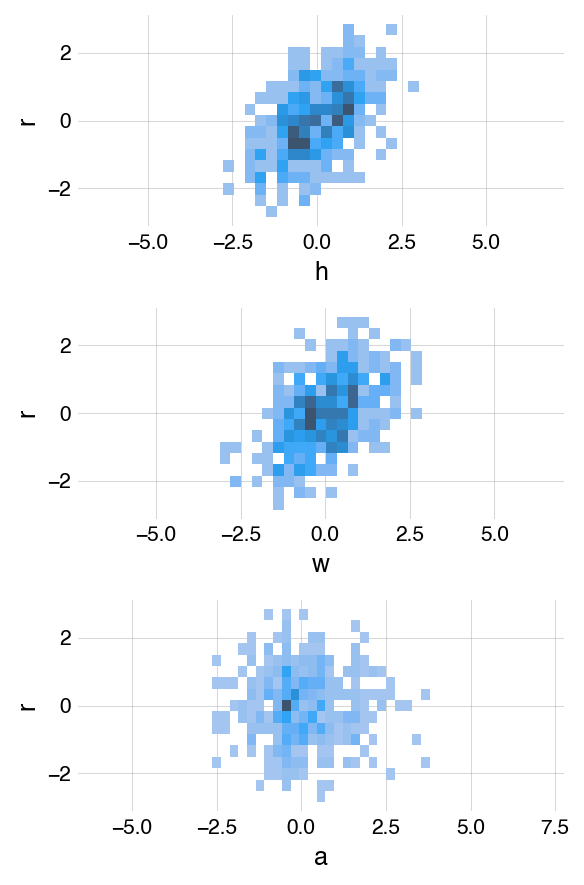

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(4, 6))
sns.histplot(df, x="h", y="r", ax=axs[0])
sns.histplot(df, x="w", y="r", ax=axs[1])
sns.histplot(df, x="a", y="r", ax=axs[2])
for ax in axs:
    ax.axis("equal")
fig.tight_layout()

<Axes: xlabel='r', ylabel='Count'>

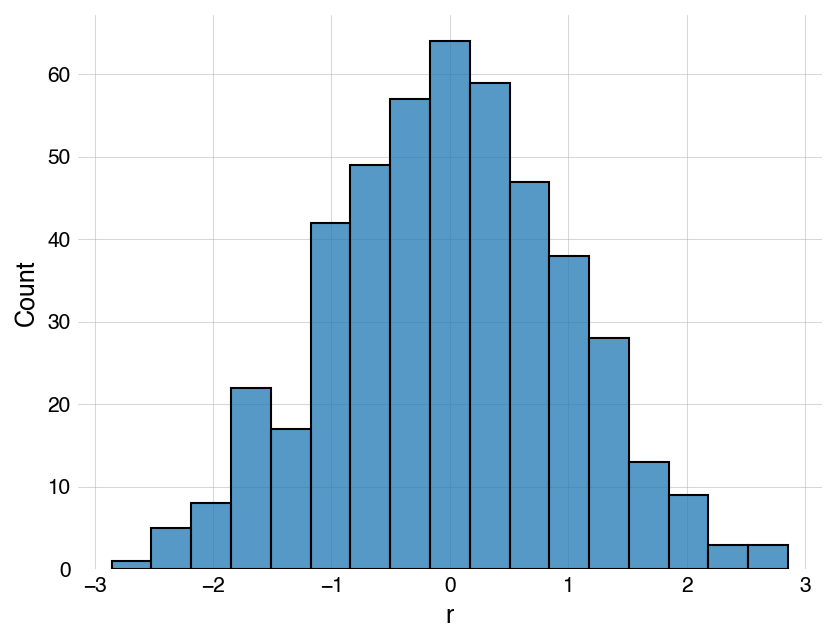

In [15]:
sns.histplot(df, x="r")

In [16]:
individual_division_model = rank_models.setup_division_regression(
    xft, year, competitionType, workoutNumber, divisionName
)

  465 records


In [17]:
df = xft.xs(key=(year, competitionType, workoutNumber, divisionName))
df = df[["r", "h", "w", "a"]].dropna()
df.shape

(465, 4)

In [18]:
sm.OLS(df.r.values, df[["h", "w", "a"]].values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.292
Model:                            OLS   Adj. R-squared (uncentered):              0.287
Method:                 Least Squares   F-statistic:                              63.42
Date:                Mon, 01 Apr 2024   Prob (F-statistic):                    2.35e-34
Time:                        17:21:21   Log-Likelihood:                         -573.47
No. Observations:                 465   AIC:                                      1153.
Df Residuals:                     462   BIC:                                      1165.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3591      0.055      6.545      0.000       0.251       0.467
x2             0.2599      0.054      4.829      0.000       0.154       0.366
x3            -0.0177      0.038     -0.462      0.644      -0.093       0.058
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.280
Skew:                           0.053   Prob(JB):                        0.870
Kurtosis:                       3.055   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
with individual_division_model:
    post = pm.sample(cores=8, chains=8, tune=2_000, draws=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [a, b, sigma]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 3 seconds.


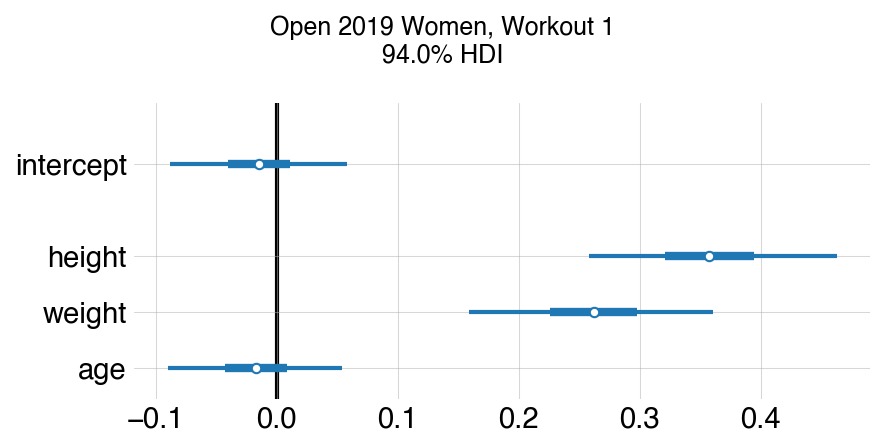

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
az.plot_forest(
    post,
    combined=True,
    var_names=["a", "b"],
    ax=ax,
)
ax.axvline(0, color="k", zorder=-1)
ax.grid(True)
ax.set_yticklabels(["age", "weight", "height", "intercept"])
fig.suptitle(
    f"{competitionType.title()} {year} {divisionName}, Workout {workoutNumber}\n{ax.get_title()}"
)
ax.set_title(None)
fig.tight_layout()

## hierarchical multiple regression for one event, using all divisions

In [27]:
model = rank_models.setup_event_regression(xft, 2021, "open", 1)

Men               459 records
Men (35-39)       455 records
Men (40-44)       453 records
Men (45-49)       436 records
Men (50-54)       456 records
Men (55-59)       432 records
Men (60-64)       444 records
Men (65+)         403 records
Women             455 records
Women (35-39)     409 records
Women (40-44)     405 records
Women (45-49)     405 records
Women (50-54)     390 records
Women (55-59)     368 records
Women (60-64)     329 records
Women (65+)       266 records


In [28]:
with model:
    post = pm.sample(cores=16, chains=16, tune=2_000, draws=2_000, target_accept=0.925)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]


Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 128 seconds.


In [33]:
var_names = list(
    filter(
        lambda c: "b" in c or c == "mu",  # or "correlation" in c or c == "stds",
        post.posterior.data_vars,
    )
)
var_names

['mu',
 'b Men',
 'b Men (35-39)',
 'b Men (40-44)',
 'b Men (45-49)',
 'b Men (50-54)',
 'b Men (55-59)',
 'b Men (60-64)',
 'b Men (65+)',
 'b Women',
 'b Women (35-39)',
 'b Women (40-44)',
 'b Women (45-49)',
 'b Women (50-54)',
 'b Women (55-59)',
 'b Women (60-64)',
 'b Women (65+)']

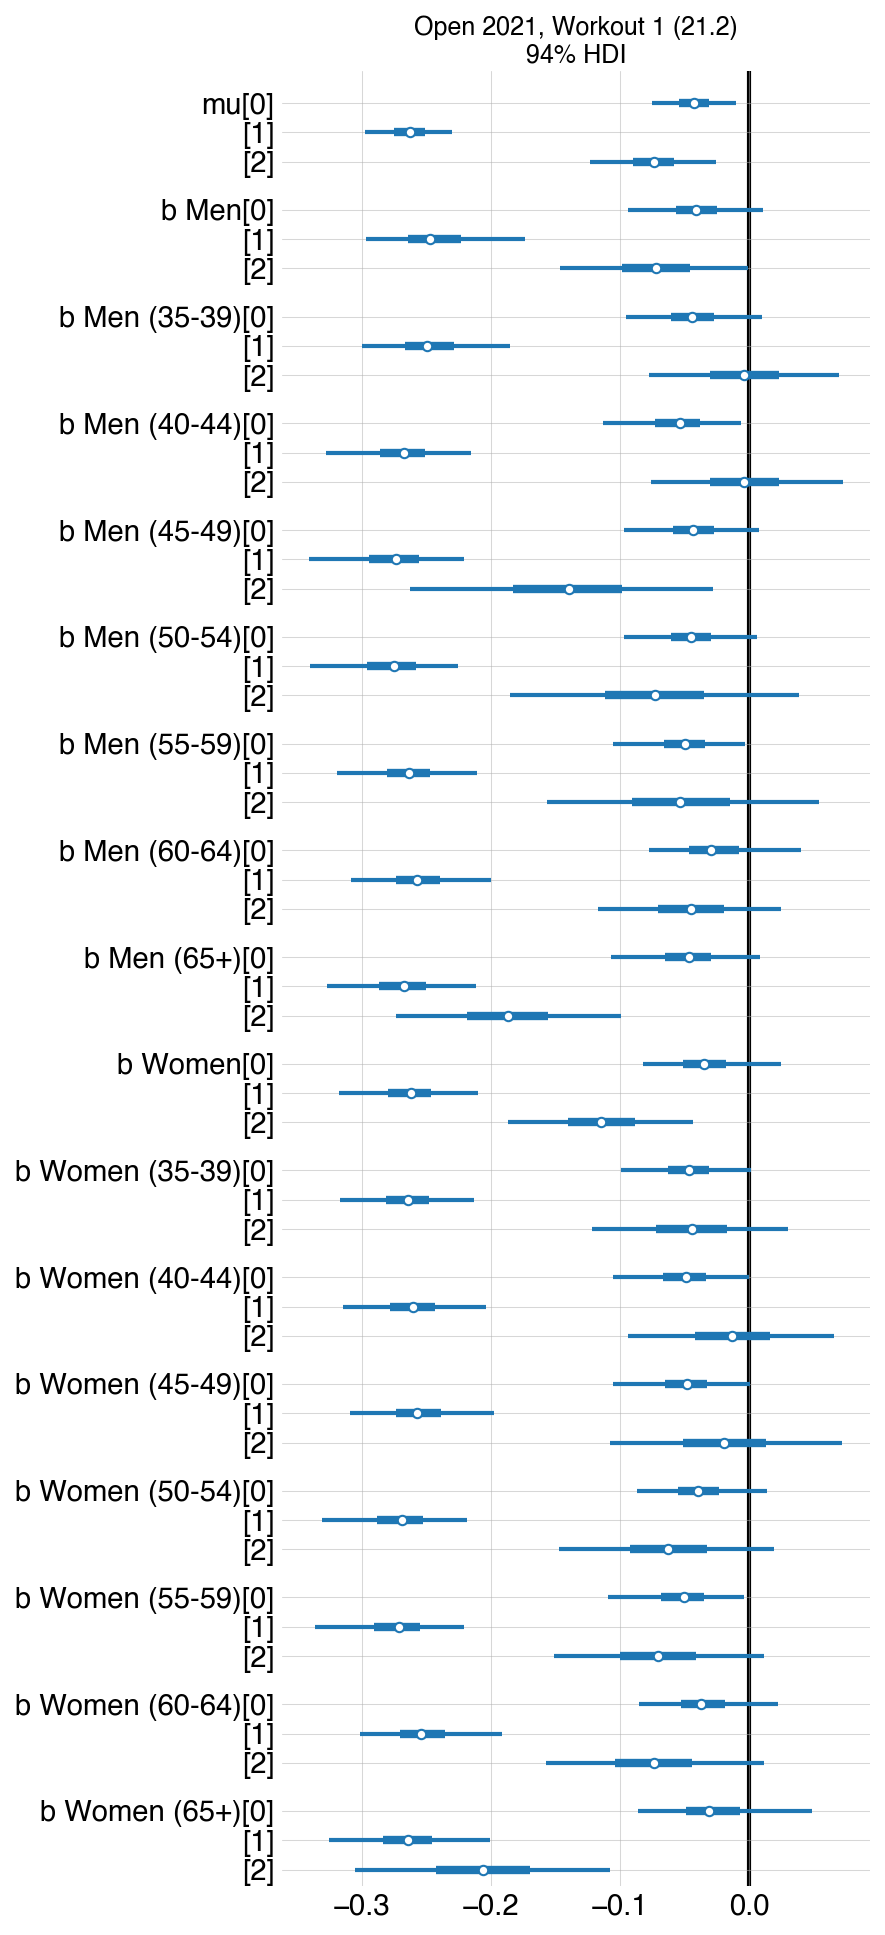

In [40]:
fig, ax = plt.subplots(figsize=(6, 13))
axs = az.plot_forest(
    post.posterior,
    # [prior.prior, post.posterior],
    # model_names=["prior", "posterior"],
    var_names=var_names,
    combined=True,
    ax=ax,
)
ax.axvline(0, color="k", zorder=-1)
ax.grid(True)
ax.set_title("Open 2021, Workout 1 (21.2)\n94% HDI")
fig.tight_layout()

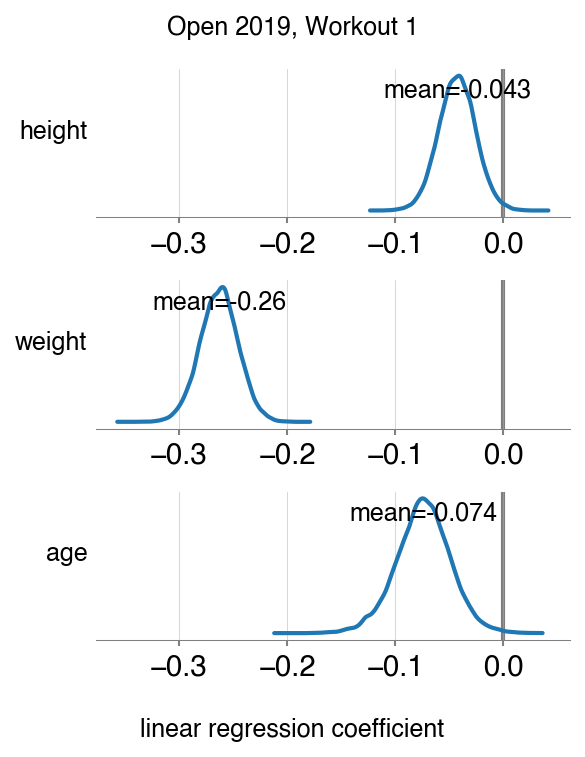

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(4, 5), sharex=True)
az.plot_posterior(post, var_names="mu", hdi_prob="hide", ax=axs)
for ax, label in zip(axs, ["height", "weight", "age"]):
    ax.axvline(0, color="k", alpha=0.5, zorder=-1)
    ax.set_ylabel(label, rotation=0, ha="right")
    ax.set_title(None)
fig.supxlabel("linear regression coefficient")
fig.suptitle(f"{competitionType.title()} {year}, Workout {workoutNumber}")
plt.gcf().tight_layout()

## several hierarchical regressions for different events

In [42]:
keys = [
    (2024, "open", 1),
    (2024, "open", 2),
    (2024, "open", 3),
]

In [43]:
posteriors = []
for key in keys:
    model = rank_models.setup_event_regression(xft, *key, silent=True)
    with model:
        posteriors.append(
            pm.sample(
                cores=16,
                chains=16,
                tune=2_000,
                draws=2_000,
                target_accept=0.925,
                progressbar=False,
            )
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 102 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 124 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller th

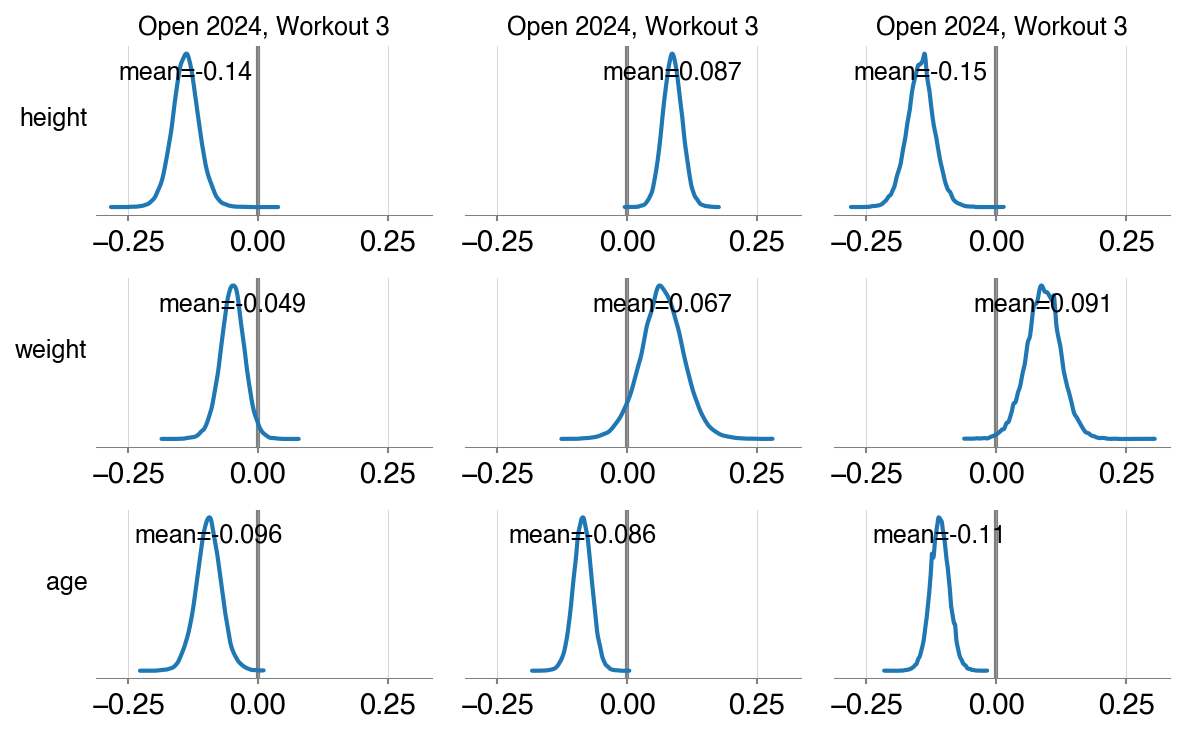

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(8, 5), sharex=True)
for i in range(3):
    az.plot_posterior(posteriors[i], var_names="mu", hdi_prob="hide", ax=axs[:, i])
for ax in axs.flatten():
    ax.axvline(0, color="k", alpha=0.5, zorder=-1)
    ax.set_title(None)
for ax, label in zip(axs[:, 0], ["height", "weight", "age"]):
    ax.set_ylabel(label, rotation=0, ha="right")
for j in range(3):
    key = keys[i]
    axs[0, j].set_title(f"{key[1].title()} {key[0]}, Workout {key[2]}", fontsize=12)
fig.tight_layout()

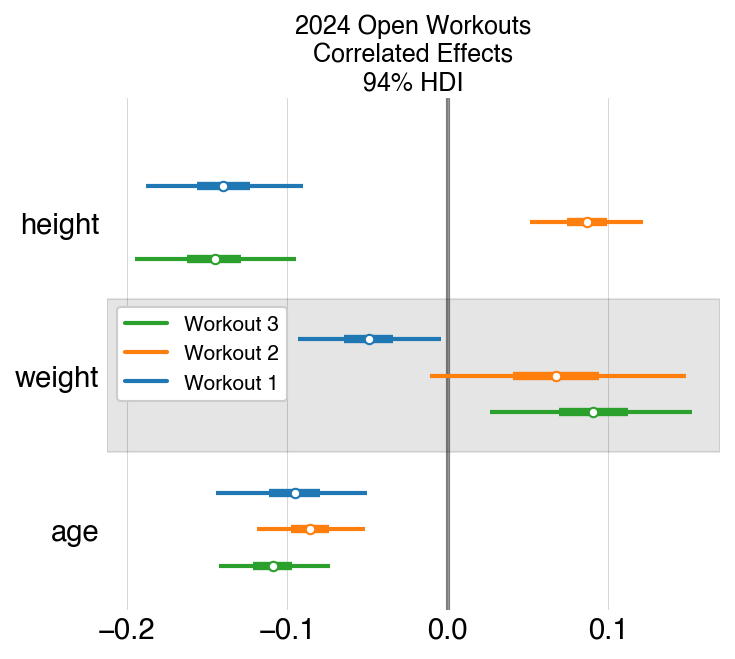

In [45]:
fig, ax = plt.subplots(figsize=(5, 4.5))
az.plot_forest(
    posteriors,
    model_names=["Workout 1", "Workout 2", "Workout 3"],
    var_names=["mu"],
    combined=True,
    ax=ax,
)
ax.axvline(0, color="k", alpha=0.5, zorder=-1)
ax.set_yticklabels(["age", "weight", "height"])
ax.set_title("2024 Open Workouts\nCorrelated Effects\n94% HDI")
fig.tight_layout()